In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import floor

%matplotlib inline 

In [ ]:
#flag_input = 'n'   # to train n stocks
flag_input = 'i'   # for a specific stock  
id = 'aapl'  # id for specific stock
n = 20      # numebr of stocks you want to train if you choose n.
path = "http://users.uoa.gr/~sdi1800133/emiris/dataset.csv"


# the following parameter is used to save or load model. You can use also default to dont do anything.
#mode = 'load'
mode = 'default'
#mode = 'save'

#path to save model if you want
path_save = '/content/drive/MyDrive/Colab_Notebooks/7_eksamino/emiris/tmp_model'

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))


def get_dataset(path):
  df = pd.read_csv(path, index_col=0 , sep=r'\t', engine='python', header=None)

  train_df = df.iloc[:349]
  test_df = df.iloc[349:]
  return train_df, test_df , df

train_df , test_df , df = get_dataset(path)

df.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a,11.1440,10.4710,10.8280,10.6980,10.9100,10.9760,11.5770,11.9130,11.9060,12.2380,12.6430,12.8600,13.4410,13.2640,13.0360,12.6840,12.690,12.7520,12.7170,12.7710,12.9870,12.9870,13.2050,13.0010,12.8660,12.7520,12.6570,12.7710,13.0610,13.1980,13.1980,13.4410,13.7020,13.4930,14.372,14.6350,14.6940,14.216,14.6470,14.9520,...,65.946,66.036,65.956,65.787,65.647,64.599,63.98,64.26,63.8500,64.07,64.87,65.15,65.83,65.70,66.36,66.56,66.60,66.62,67.54,66.99,66.91,66.12,66.44,66.88,67.25,67.02,67.32,67.39,67.71,67.97,67.49,68.03,68.02,68.13,68.37,68.22,68.25,68.11,67.47,66.81
aa,47.4580,45.8700,46.2490,47.8520,49.5240,49.7790,50.9660,50.8400,50.1720,51.3840,52.8290,52.3440,54.2480,53.9490,54.1400,53.2420,54.183,54.4540,54.5740,53.4090,54.8710,55.5370,55.5370,55.0160,54.7880,52.3440,52.1200,51.1780,52.7000,52.3860,53.2420,53.2420,53.3040,52.8290,53.681,53.8870,53.1770,52.097,52.7640,52.4240,...,44.910,46.200,47.500,46.250,45.380,45.290,44.74,45.07,46.0800,46.62,47.65,48.31,47.91,48.25,47.49,47.07,46.89,46.94,47.53,47.71,48.24,47.77,47.75,46.54,47.93,47.93,50.08,49.52,49.15,47.91,47.42,47.78,47.70,47.46,47.12,47.29,46.97,45.89,43.33,43.01
aaba,13.8800,12.9700,13.2900,13.0900,13.4500,14.2400,14.9800,14.9500,15.0700,14.9200,14.3300,14.2800,14.7900,14.7000,13.9700,13.7500,13.950,14.8000,14.8500,14.3600,15.3300,15.7100,16.1500,15.8100,16.0700,15.7600,15.6800,15.6800,16.4300,16.1100,16.3500,16.8200,17.1800,17.4300,17.640,17.5500,17.6400,16.280,16.0900,16.1000,...,67.110,67.430,66.920,66.590,67.340,64.960,64.45,65.80,65.5803,66.24,66.51,67.81,67.66,67.72,67.85,68.74,68.93,69.22,67.91,67.52,68.04,66.78,67.79,67.45,67.51,66.51,66.61,65.40,65.57,67.52,68.86,70.12,70.59,70.51,70.23,71.71,72.22,71.16,70.19,70.56
aapl,1.2037,1.1589,1.1385,1.1437,1.1679,1.1731,1.2089,1.1704,1.1589,1.1487,1.1167,1.1078,1.1271,1.1294,1.0974,1.0744,1.100,1.1167,1.1371,1.1153,1.1691,1.1655,1.2241,1.2254,1.2294,1.2204,1.2026,1.2217,1.2347,1.1999,1.2204,1.2217,1.2334,1.2241,1.273,1.3065,1.2743,1.254,1.2717,1.2743,...,158.100,158.160,155.510,152.840,151.350,150.010,152.59,153.68,152.7300,153.57,153.26,153.92,152.93,154.83,154.74,155.28,155.34,155.99,155.44,156.43,159.31,159.90,159.19,155.42,155.69,155.61,156.54,155.85,156.85,162.47,166.12,168.43,166.29,167.51,171.88,173.63,174.18,175.61,175.25,174.67
abc,13.9910,13.4340,13.1950,13.4150,13.4710,13.4250,13.5920,13.7040,13.8990,14.2500,14.2450,14.2220,14.4960,15.2040,15.6960,15.1270,15.213,15.3580,15.3690,15.0610,15.6620,15.8540,15.6270,15.4360,15.9410,15.5330,15.4170,15.6140,15.9140,15.8410,15.7660,15.9410,16.1960,16.1830,16.665,16.4110,16.1550,15.691,15.7850,15.7940,...,80.670,79.280,79.500,80.380,81.050,80.980,82.00,82.43,80.9900,82.75,83.30,82.88,82.74,84.12,80.48,78.35,79.55,80.32,80.80,79.44,79.00,79.95,80.49,82.20,83.21,82.53,81.85,82.22,78.77,76.38,76.93,76.95,76.62,73.23,74.80,74.86,74.91,75.01,75.27,75.00


In [ ]:

split_percent = floor(df.shape[1] * 0.8)

if flag_input == 'i':
  set_ = df.loc[id]
  train_set = set_.iloc[ :split_percent ].values
  test_set = set_.iloc[ split_percent: ].values
elif flag_input == 'n':
  set_ = df.iloc[:n]
  train_set = set_.iloc[:, :split_percent].values
  train_set = train_set.flatten()
  test_set = set_.iloc[:, split_percent: ].values


## use minMax Scaler
scaled = scaler.fit_transform(train_set.reshape(-1,1))
scaled.shape


(2920, 1)

In [ ]:
def split_intervals(input, n_timestamps):
  X = []
  y = []
  len = input.shape[0]

  for i in range(n_timestamps, len):
    X.append(input[i-n_timestamps:i])
    y.append(input[i])

  X = np.array(X)
  y = np.array(y)
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  y = np.reshape(y, (y.shape[0], 1))
  return X, y

In [ ]:
n_timestamps = 50

input = scaled

X, y = split_intervals(input, n_timestamps)
print(X.shape, y.shape)

(2870, 50, 1) (2870, 1)


In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers  import LSTM
from keras.layers import Dense
from keras.layers  import Dropout

class Model:
  def __init__(self, n_epochs, batch_siz, n_timestamps, n_units, mode = 'default'):
    self.epochs = n_epochs
    self.batch_size = batch_siz

    # define our LSTM model
    self.model = keras.models.Sequential()

    # add LSTM layers
    self.model.add(LSTM(units = n_units, activation='relu', return_sequences = True, input_shape = (n_timestamps, 1)))
    self.model.add(Dropout(0.3))

    self.model.add(LSTM(units = n_units, activation='relu', return_sequences = True))
    self.model.add(Dropout(0.3))

    self.model.add(LSTM(activation='relu', units = n_units))
    self.model.add(Dropout(0.3))

    # output layer
    self.model.add(Dense(units = 1))

  def compile_fit(self, X ,y , optimize='adam', loss_fun='mean_squared_error', mode = 'default'):

    if mode != 'load':
      self.model.compile(optimizer=optimize, loss=loss_fun, metrics=[tf.metrics.MeanAbsoluteError()])
      self.model.fit(X, y, epochs = self.epochs, batch_size = self.batch_size,  validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')])
      if mode == 'save': 
        self.model.save(path_save)

    elif mode == 'load':
      self.model = keras.models.load_model(path_save)
  
  def predict(self, X_test):
    return self.model.predict(X_test)



In [ ]:
n_epochs = 10
if flag_input == 'i':
  batch_size=64
else:
  batch_size = 1024
n_units = 50

neuralnet = Model(n_epochs, batch_size, n_timestamps, n_units, mode)
neuralnet.compile_fit(X, y, mode=mode)


Epoch 1/10
36/36 [==============================] - 8s 112ms/step - loss: 0.0216 - mean_absolute_error: 0.0972 - val_loss: 0.0094 - val_mean_absolute_error: 0.0869
Epoch 2/10
36/36 [==============================] - 3s 96ms/step - loss: 0.0037 - mean_absolute_error: 0.0412 - val_loss: 0.0048 - val_mean_absolute_error: 0.0617
Epoch 3/10
36/36 [==============================] - 4s 99ms/step - loss: 0.0027 - mean_absolute_error: 0.0334 - val_loss: 0.0017 - val_mean_absolute_error: 0.0305
Epoch 4/10
36/36 [==============================] - 4s 98ms/step - loss: 0.0023 - mean_absolute_error: 0.0306 - val_loss: 0.0028 - val_mean_absolute_error: 0.0404
Epoch 5/10
36/36 [==============================] - 4s 100ms/step - loss: 0.0024 - mean_absolute_error: 0.0298 - val_loss: 0.0014 - val_mean_absolute_error: 0.0304
Epoch 6/10
36/36 [==============================] - 3s 96ms/step - loss: 0.0021 - mean_absolute_error: 0.0286 - val_loss: 0.0013 - val_mean_absolute_error: 0.0274
Epoch 7/10
36/36 [==

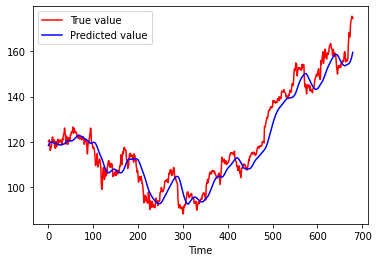

In [ ]:
if flag_input == 'i':
  input = scaler.fit_transform(test_set.reshape(-1,1))

  X_test, y_test = split_intervals(input, n_timestamps)
  predictions = neuralnet.predict(X_test)
  predicted_stock_price = scaler.inverse_transform(predictions)

  x_axis_values = [i for i in range(predicted_stock_price.shape[0])]
  plt.plot(x_axis_values,test_set[n_timestamps:], color = 'red', label = 'True value')
  plt.plot(x_axis_values,predicted_stock_price, color = 'blue', label = 'Predicted value')
  plt.xlabel('Time')
  plt.legend()
  plt.show()

if flag_input == 'n':
  fig, axs = plt.subplots(n,1, figsize=(10,6*n), squeeze=False)

  for j in range(n):
    test_input = test_set[j, :]
    
    input = scaler.fit_transform(test_input.reshape(-1,1))

    X_test, y_test = split_intervals(input, n_timestamps)
    predictions = neuralnet.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predictions)

    x_axis_values = [i for i in range(predicted_stock_price.shape[0])]
    axs[j][0].plot(x_axis_values,test_input[n_timestamps:], color = 'red', label = 'True value')
    axs[j][0].plot(x_axis_values,predicted_stock_price, color = 'blue', label = 'Predicted value')
    axs[j][0].legend()
